In [ ]:
!nvidia-smi

Mon Oct 14 18:26:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install datasets

In [ ]:
# from datasets import load_dataset

# dataset = load_dataset("stanfordnlp/sst2")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# df = dataset['train'].to_pandas()
# df.to_csv("SST.csv", index=False)
df = pd.read_csv('https://raw.githubusercontent.com/a1rafi/SST2/main/raw_data_sst2.csv')
df.head(10)

,idx,sentence,label
0,0,hide new secretions from the parental units,0
1,1,"contains no wit , only labored gags",0
2,2,that loves its characters and communicates som...,1
3,3,remains utterly satisfied to remain the same t...,0
4,4,on the worst revenge-of-the-nerds clichés the ...,0
5,5,that 's far too tragic to merit such superfici...,0
6,6,demonstrates that the director of such hollywo...,1
7,7,of saucy,1
8,8,a depressed fifteen-year-old 's suicidal poetry,0
9,9,are more deeply thought through than in most `...,1


In [ ]:
df2 = df.copy()

## Basic EDA Information

In [ ]:
# def basic_eda(df, row_limit=5, list_elements_limit=10):
#     # Rows and columns
#     print(f'Info: There are {df.shape[1]} columns and {df.shape[0]} rows in the dataset')
#     print("==================================================")

#     # Data types
#     dtypes_df = df.dtypes.reset_index().rename(columns={0: 'dtype', 'index': 'column_name'})
#     cat_df = dtypes_df[dtypes_df['dtype'] == 'object']
#     num_df = dtypes_df[dtypes_df['dtype'] != 'object']

#     print(f"\nData type information of different columns:\n"
#           f"Info: There are {len(cat_df)} categorical columns\n"
#           f"Info: There are {len(num_df)} numerical columns")

#     print("Categorical columns:", list(cat_df['column_name'][:list_elements_limit]))
#     print("Numerical columns:", list(num_df['column_name'][:list_elements_limit]))
#     print()
#     display(dtypes_df.head(row_limit))
#     print("==================================================")

#     # Description of numerical variables
#     print("\nDescription of numerical variables")
#     desc_df_num = df[list(num_df['column_name'])].describe().T.reset_index().rename(columns={'index': 'column_name'})
#     display(desc_df_num.head(row_limit))
#     print("==================================================")

#     # Description of categorical variables
#     print("\nDescription of categorical variables")
#     desc_df_cat = df[list(cat_df['column_name'])].describe(include='all').T.reset_index().rename(
#         columns={'index': 'column_name'})
#     display(desc_df_cat.head(row_limit))

#     return

# basic_eda(df)

In [ ]:
# unique_labels = df["label"].unique()
# print("Total unique labels =",len(unique_labels))
# print(unique_labels)

# print(df.label.value_counts())

In [ ]:
df.info()
print()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   idx       67349 non-null  int64 
 1   sentence  67349 non-null  object
 2   label     67349 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB



,0
idx,0
sentence,0
label,0


# Uni grams

In [ ]:
# # Code Snippet for Top N-grams Barchart

# import seaborn as sns
# import numpy as np
# from nltk.corpus import stopwords
# from sklearn.feature_extraction.text import CountVectorizer
# from collections import  Counter

# def plot_top_ngrams_barchart(text, n=1):
#     stop=set(stopwords.words('english'))

#     new= text.str.split()
#     new=new.values.tolist()
#     corpus=[word for i in new for word in i]

#     def _get_top_ngram(corpus, n=None):
#         vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
#         bag_of_words = vec.transform(corpus)
#         sum_words = bag_of_words.sum(axis=0)
#         words_freq = [(word, sum_words[0, idx])
#                       for word, idx in vec.vocabulary_.items()]
#         words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
#         return words_freq[:10]

#     top_n_bigrams=_get_top_ngram(text,n)[:10]
#     x,y=map(list,zip(*top_n_bigrams))
#     sns.barplot(x=y,y=x)

In [ ]:
# plot_top_ngrams_barchart(df['sentence'],1)

In [ ]:
# plot_top_ngrams_barchart(df['sentence'],2)

In [ ]:
# plot_top_ngrams_barchart(df['sentence'],3)

In [ ]:
# plot_top_ngrams_barchart(df['sentence'],4)

# Model Buiding

In [ ]:
import random
import string
import re

def create_substitution_dict(seed=42):
    # Combine all required characters
    chars = string.punctuation + string.digits + string.ascii_letters
    chars = list(chars)

    # Generate pairs of characters
    pairs = [a + b for a in chars for b in chars]

    # Use only pairs in the key
    key_combined = pairs.copy()

    # Set seed and shuffle the key for consistent results
    random.seed(seed)
    random.shuffle(key_combined)

    # Ensure no character or pair maps to itself
    valid_mapping = False
    while not valid_mapping:
        substitution_dict = {original: substitute for original, substitute in zip(chars + pairs, key_combined)}
        valid_mapping = all(original != substitute for original, substitute in substitution_dict.items())
        if not valid_mapping:
            random.shuffle(key_combined)

    return substitution_dict

def sub_encrypt(plain_text, substitution_dict):
    cipher_text = ""
    i = 0
    while i < len(plain_text):
        # Attempt to find a pair first
        if i + 1 < len(plain_text):
            pair = plain_text[i:i + 2]
            if pair in substitution_dict:
                cipher_text += substitution_dict[pair]
                i += 2
                continue

        # If no valid pair, fallback to single character
        char = plain_text[i]
        cipher_text += substitution_dict.get(char, char)
        i += 1

    return cipher_text


def sub_decrypt(cipher_text, substitution_dict):
    reverse_substitution_dict = {substitute: original for original, substitute in substitution_dict.items()}
    plain_text = ""
    i = 0
    while i < len(cipher_text):
        # Attempt to find a pair first
        if i + 1 < len(cipher_text):
            pair = cipher_text[i:i + 2]
            if pair in reverse_substitution_dict:
                plain_text += reverse_substitution_dict[pair]
                i += 2
                continue

        # If no valid pair, fallback to single character
        char = cipher_text[i]
        plain_text += reverse_substitution_dict.get(char, char)
        i += 1

    return plain_text


def clean_sentence(sentence):
    # Handle potential float values
    if isinstance(sentence, float):
        sentence = str(sentence)  # Convert float to string if necessary

    # Replace commas and opening brackets with spaces to treat them as word separators
    sentence = sentence.replace(',', ' ')
    sentence = sentence.replace('(', ' ')
    sentence = sentence.replace('{', ' ')
    sentence = sentence.replace('[', ' ')
    sentence = sentence.replace('–', ' ')
    sentence = sentence.replace('—', ' ')
    sentence = sentence.replace('\n', ' ')
    sentence = sentence.replace('\t', ' ')
    sentence = sentence.replace('“', ' ')
    sentence = sentence.replace('”', ' ')
    sentence = sentence.replace('‘', ' ')
    sentence = sentence.replace('’', ' ')

    # Remove punctuation from the end of words after handling periods
    words = sentence.split()
    cleaned_words = []
    for word in words:
        if '.' in word:
            word = word.split('.')[0]  # Keep only the part before the first full stop
        cleaned_words.append(word)

    # Join the cleaned words and remove any remaining punctuation
    cleaned_sentence = ' '.join(cleaned_words)
    cleaned_sentence = cleaned_sentence.translate(str.maketrans('', '', string.punctuation))
    # Use regex to remove all non-alphanumeric characters except spaces
    cleaned_sentence = re.sub(r'[^a-zA-Z0-9\s]', '', cleaned_sentence)
    # Convert to lowercase
    cleaned_sentence = cleaned_sentence.lower()

    return cleaned_sentence


# # Example usage
# substitution_dict = create_substitution_dict(seed=42)

# plain_text = "king"
# cipher_text = sub_encrypt(plain_text, substitution_dict)
# decrypted_text = sub_decrypt(cipher_text, substitution_dict)

# print(f"Plain Text: {plain_text}")
# print(f"Cipher Text: {cipher_text}")
# print(f"Decrypted Text: {decrypted_text}")


In [ ]:
substitution_dict = create_substitution_dict()
first_words = []

for index, row in df.iterrows():
    # Split the sentence into words
    plaintext = row['sentence']

    encrypted_mod = sub_encrypt(clean_sentence(plaintext), substitution_dict)
    encrypted_org = sub_encrypt(plaintext, substitution_dict)

    first_words.append((encrypted_mod, encrypted_org))

df['substituted_text'] = first_words

# Print the DataFrame with the new column
# df

In [ ]:
encrypted_mod = sub_encrypt(clean_sentence("first citizen:"), substitution_dict)
print(encrypted_mod)

=H&9]O F2V)K1A"


In [ ]:
!pip install cryptography

In [ ]:
import math
import string

def generate_keypair(p, q):
    # Generate public and private keys based on prime numbers p and q
    n = p * q
    phi = (p - 1) * (q - 1)

    e = 2
    while math.gcd(e, phi) != 1:
        e += 1

    d = pow(e, -1, phi)

    return (n, e), (n, d)

def base_convert(number, base_chars):
    # Convert a number to a string using the given base characters
    base = len(base_chars)
    result = []
    while number > 0:
        result.append(base_chars[number % base])
        number //= base
    return ''.join(reversed(result)) if result else base_chars[0]

def base_convert_back(encoded, base_chars):
    # Convert a string back to a number using the given base characters
    base = len(base_chars)
    number = 0
    for char in encoded:
        number = number * base + base_chars.index(char)
    return number

def encrypt(public_key, plaintext):
    # Encrypt plaintext using public key
    n, e = public_key
    base_chars = string.ascii_letters  # 'A' to 'Z' and 'a' to 'z'
    ciphertext = []
    for char in plaintext:
        if char == ' ':
            ciphertext.append(' ')
        else:
            encrypted_char = base_convert(pow(ord(char), e, n), base_chars)
            ciphertext.append(encrypted_char)
            ciphertext.append('|')  # Separator for encrypted characters
    return ''.join(ciphertext).rstrip('|')  # Remove the trailing separator

def decrypt(private_key, ciphertext):
    # Decrypt ciphertext using private key
    n, d = private_key
    base_chars = string.ascii_letters  # 'A' to 'Z' and 'a' to 'z'
    plaintext = []
    current_chunk = []
    i = 0
    while i < len(ciphertext):
        char = ciphertext[i]
        if char == ' ':
            if current_chunk:
                encoded_str = ''.join(current_chunk)
                decrypted_char = chr(pow(base_convert_back(encoded_str, base_chars), d, n))
                plaintext.append(decrypted_char)
                current_chunk = []
            plaintext.append(' ')
            i += 1
        elif char == '|':
            encoded_str = ''.join(current_chunk)
            decrypted_char = chr(pow(base_convert_back(encoded_str, base_chars), d, n))
            plaintext.append(decrypted_char)
            current_chunk = []
            i += 1
        else:
            current_chunk.append(char)
            i += 1
    if current_chunk:  # For the last chunk if there's no trailing separator
        encoded_str = ''.join(current_chunk)
        decrypted_char = chr(pow(base_convert_back(encoded_str, base_chars), d, n))
        plaintext.append(decrypted_char)
    return ''.join(plaintext)

# # Example usage:
# p = 61  # Prime number
# q = 53  # Prime number
# public_key, private_key = generate_keypair(p, q)

# plaintext = "<=g6 W =qo p b#xx J(S &@(k&@]E(gg(o"
# encrypted = encrypt(public_key, plaintext)
# print("Encrypted:", encrypted)

# decrypted = decrypt(private_key, encrypted)
# print("Decrypted:", decrypted)


In [ ]:

first_words = []
keys = []
p = 61  # Prime number
q = 53  # Prime number

# Loop through each row of the 'sentence' column
for index, row in df.iterrows():
    # Split the sentence into words
    plaintext = row['substituted_text']
    public_key, private_key = generate_keypair(p, q)

    en_mod = encrypt(public_key, plaintext[0])
    en_org = encrypt(public_key, plaintext[1])
    keys.append((public_key, private_key))
    first_words.append((en_mod, en_org))

# Add the list of first words as a new column to the DataFrame
df['Encrypted_text'] = first_words

# Print the DataFrame with the new column
# print(df)

In [ ]:
first_wordsss = []
for index, row in df.iterrows():
    # Split the sentence into words
    encrypted = row['Encrypted_text']

    decry_mod = decrypt(private_key, encrypted[0])
    decry_org = decrypt(private_key, encrypted[1])
    # Get the first word

    # Append the first word to the list
    first_wordsss.append((decry_mod, decry_org))

# Add the list of first words as a new column to the DataFrame
df['decrypted_text'] = first_wordsss

In [ ]:
#df.drop('first_word', axis=1, inplace=True)
df

,idx,sentence,label,sentence_length,substituted_text,Encrypted_text,decrypted_text
0,0,hide new secretions from the parental units,0,44,(e#^; [:tK ?n#bxizhI% ^HQ[ Q+EZ YT.Tr^&I EOzG0...,(bhd|oW|QY|Eu| xI|TW|HU|qK| Oa|DK|oW|bei|bd|bg...,(e#^; [:tK ?n#bxizhI% ^HQ[ Q+EZ YT.Tr^&I EOzG0...
1,1,"contains no wit , only labored gags",0,36,"(@-r^|)I% c9 0E]O 17ug mo,8.Tn_ .h}Y, @-r^|)I%...",(Zx|HM|ID|QY|bew|bah|fA|GK| y|nu| VS|cZ|zk|rD|...,"(@-r^|)I% c9 0E]O 17ug mo,8.Tn_ .h}Y, @-r^|)I%..."
2,2,that loves its characters and communicates som...,1,89,(Q+T0 qtJ_0L zG0L %aBQ.Dz-&9 IEn_ @-N=EODjT0zj...,(WN|vi|Fl|VS| Eg|HU|tb|Rs|VS|bF| EA|wP|VS|bF| ...,(Q+T0 qtJ_0L zG0L %aBQ.Dz-&9 IEn_ @-N=EODjT0zj...
3,3,remains utterly satisfied to remain the same t...,0,56,(.TUk3e0L nnz-0*[f LpV)/~4*n_ #r .TUk3e Q+EZ L...,(vT|Fl|Wn|PQ|Fj|bhd|VS|bF| DK|DK|EA|HM|VS|eG|x...,(.TUk3e0L nnz-0*[f LpV)/~4*n_ #r .TUk3e Q+EZ L...
4,4,on the worst revenge-of-the-nerds clichés the ...,0,73,(17 Q+EZ yX&9]O .TJ_p6!G)B2K[:6M0L veDjYo Q+EZ...,(mf|bgB| WN|vi|cZ|BF| od|Ry|gr|nu|zk|rD| vT|Fl...,(17 Q+EZ yX&9]O .TJ_p6!G)B2K[:6M0L veDjYo Q+EZ...
...,...,...,...,...,...,...,...
67344,67344,a delightful comedy,1,20,"(r} ^;feKd+#aT @-fG\U, r} ^;feKd+#aT @-fG\U )",(ID|Kk| QY|Eu|le|bhd|qK|bdm|vi|oW|IY|Fl| Zx|HM...,"(r} ^;feKd+#aT @-fG\U, r} ^;feKd+#aT @-fG\U )"
67345,67345,"anguish , anger and frustration",0,32,"(IE[a{Tsc IEH1'X IEn_ ^Hg+qDT0zhA"", IE[a{Tsc $...",(fA|cZ|xI|IY|bdi|Fl|kV|y| fA|cZ|uV|mf|wu|Ry| f...,"(IE[a{Tsc IEH1'X IEn_ ^Hg+qDT0zhA"", IE[a{Tsc $..."
67346,67346,"at achieving the modest , crowd-pleasing goals...",1,66,(T0 .De#cs3evT Q+EZ R5^;}@ #bmHzvhUcK3evT L9&I...,(Fl|VS| vT|NC|bhd|oW|y|kV|Fj|bhd|IA|Fl| WN|vi|...,(T0 .De#cs3evT Q+EZ R5^;}@ #bmHzvhUcK3evT L9&I...
67347,67347,a patient viewer,1,17,"(r} YTV)%&]O I/:EZW, r} YTV)%&]O I/:EZW )",(ID|Kk| dY|Fl|In|bah|GK|gr|zk|rD| fA|dn|TW|cZ|...,"(r} YTV)%&]O I/:EZW, r} YTV)%&]O I/:EZW )"


In [ ]:
# # ENCRYPT
# with open('all_bi_cypher_tokens.txt', 'r', encoding='utf-8') as file:
#     tokens = file.read().splitlines()

# #print(tokens)

# encryptedTokens=[]
# for i in tokens:
#   plain_text = i
#   cipher_text = ""
#   for letter in plain_text:
#         cipher_text += letter
#   encryptedTokens.append(cipher_text)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gensim.models import Word2Vec
word2vec_model=Word2Vec.load('/content/drive/MyDrive/Thesis [G-suite]/Defense/Embedding Models/Word2Vec_SkipGram (4, 35)/word2vec_model.bin')

In [ ]:


import io

metadata = []
for word in word2vec_model.wv.index_to_key:
  metadata.append(word)

out_v = io.open('metadata.tsv', 'w', encoding='utf-8')
for word in metadata:
  out_v.write(word + '\n')
out_v.close()


In [ ]:
# ENCRYPT
with open('metadata.tsv', 'r', encoding='utf-8') as file:
    tokens = file.read().splitlines()

#print(tokens)

encryptedTokens=[]
for i in tokens:
  plain_text = i
  cipher_text = ""
  for letter in plain_text:
        cipher_text += letter
  encryptedTokens.append(cipher_text)

In [ ]:
print(encryptedTokens[:20])
Tokens = encryptedTokens
print(len(Tokens))

['Q+EZ', 'n]', '3e', 'IEn_', 'r}', '#r', '+U0L', '{T', ";]'X", '17', 'cK', '0EQ+', 'Mm', '2K', 'Q+T0', 'T0', '^HQ[', 'e#0L', 'zG', 'IE']
421665


In [ ]:
# with open('all_bi_cypher_Stopwords.txt', 'r', encoding='utf-8') as file:
#     stopwords = file.read().splitlines()

# print(stopwords)

# with open('nltk_stopwords.txt', 'r', encoding='utf-8') as file:
#     stop = file.read().splitlines()
# stopwords = []
# for i in stop:
#     stopwords.append(clean_sentence(i))
# print(stopwords)

In [ ]:

# print(len(encryptedTokens))
# for x in encryptedTokens:
#   if x in stopwords:
#     encryptedTokens.remove(x)
# print(len(encryptedTokens))


In [ ]:
word_index = {'[UNK]':0}
count = 1
for i in encryptedTokens:
  if (i not in word_index):
    word_index[i] = count
    count += 1
#print(word_index)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
%matplotlib inline

import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import pickle

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Splitting the data into training and testing sets

df['first_element'] = df['decrypted_text'].apply(lambda x: x[0])

X_train, X_test, y_train, y_test = train_test_split(df['first_element'], df['label'], test_size=0.2, random_state=42)


In [ ]:
def texts_to_sequences(text):
  sequences = []
  for i in text:
    sequences.append([word_index[word] if word in word_index else word_index["[UNK]"] for word in i.split()])
  return sequences

In [ ]:
# max_words = len(word_index)
# max_sequence_length = 100

# Hyperparameters of the model

# EMBEDDING_DIM = 100
max_sequence_length = 25
# VOCAB_SIZE = len(word_index)+1

X_train_sequence = texts_to_sequences(X_train)
X_test_sequence = texts_to_sequences(X_test)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=max_sequence_length)

In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# # Checking the mapping
# class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
# print("Class Mapping:")
# for class_label, encoded_value in class_mapping.items():
#     print(f"{class_label}: {encoded_value}")

In [ ]:
with open('metadata.tsv', 'r', encoding='utf-8') as file:
    vocab = file.read().splitlines()

print(vocab[:20])
print(len(vocab))

['Q+EZ', 'n]', '3e', 'IEn_', 'r}', '#r', '+U0L', '{T', ";]'X", '17', 'cK', '0EQ+', 'Mm', '2K', 'Q+T0', 'T0', '^HQ[', 'e#0L', 'zG', 'IE']
421665


In [ ]:
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Embedding, LSTM, Dense
# from tensorflow.keras.optimizers import Adam

# # Define max_sequence_length
# max_sequence_length = 10  # This should match the output_sequence_length from TextVectorization

# # Load the embeddings and vocabulary
# embedding_dim = 200  # Same as the embedding_dim used in Word2Vec training
# vocab_size = 245760  # Same as the vocab_size used in Word2Vec training

# # Create a dictionary to map words to their embeddings
# embedding_index = {}
# with open('vectors.tsv', encoding='utf-8') as f_vectors, open('metadata.tsv', encoding='utf-8') as f_metadata:
#     for word, vector in zip(f_metadata, f_vectors):
#         word = word.strip()
#         vector = np.array(vector.split(), dtype=np.float32)
#         # embedding_index[word] = vector

#         # Check if the embedding vector has the correct dimension
#         if vector.shape == (embedding_dim,):
#             embedding_index[word] = vector
#         else:
#             print(f"Warning: Skipping word '{word}' due to incorrect embedding dimension: {vector.shape}")

# # Initialize the embedding matrix with zeros
# embedding_matrix = np.zeros((vocab_size, embedding_dim))

# # Populate the embedding matrix with the vectors from the pretrained embeddings
# for i, word in enumerate(vocab):
#     if i == 0:
#         continue  # Skip padding token
#     embedding_vector = embedding_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

# # Define the LSTM model
# model = Sequential()

# # The Embedding Layer initialized with the pretrained embeddings
# model.add(Embedding(input_dim=vocab_size,
#                     output_dim=embedding_dim,
#                     input_length=max_sequence_length,
#                     weights=[embedding_matrix],
#                     trainable=True))  # Set trainable to False to keep embeddings fixed

# # Add LSTM and Dense layers
# model.add(LSTM(128))  # Ensure LSTM is properly added with 128 units
# model.add(Dense(64, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model with a specific learning rate
# learning_rate = 0.00001
# optimizer = Adam(learning_rate=learning_rate)
# model.compile(loss='BinaryCrossentropy', optimizer=optimizer, metrics=['accuracy'])
# model.build((None,max_sequence_length))
# # Print the model summary
# model.summary()


# # # Training the Model with GPU
# # with tf.device('/GPU:1'):
# #     history = model.fit(X_train_padded, y_train, epochs=10, batch_size=64, validation_split=0.1, validation_steps=30, verbose=1)

# # # Saving the model to a file
# # model.save('LSTM.h5')


In [ ]:
print(sub_encrypt("happy",substitution_dict))
print(sub_decrypt("fkjshf}",substitution_dict))

Ni%x[f
mq0@!{}


In [ ]:
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, Dropout

# word2vec_model=Word2Vec.load('/content/drive/MyDrive/Thesis [G-suite]/Defense/Embedding Models/Word2Vec_SkipGram_New/word2vec_model.bin')
# Define max_sequence_length
max_sequence_length = 25  # This should match the output_sequence_length from TextVectorization

embedding_dim = 256  # Embedding dimension used in FastText
vocab_size = len(word2vec_model.wv.index_to_key) + 1  # Vocab size based on Word2Vec model

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with Word2Vec embeddings
for i, word in enumerate(word2vec_model.wv.index_to_key):
    embedding_vector = word2vec_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i + 1] = embedding_vector

# Define the LSTM model
model = Sequential()

# The Embedding Layer initialized with the pretrained embeddings
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length,
                    weights=[embedding_matrix],
                    trainable=False))  # Set trainable to False to keep embeddings fixed

# Add LSTM and Dense layers
model.add(LSTM(256))
# model.add(Bidirectional(LSTM(256)))
# model.add(LSTM(256, return_sequences=True))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#model.add(LSTM(128))  # Ensure LSTM is properly added with 128 units
#model.add(Dropout(0.2))  # Dropout layer with 50% dropout rate
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a specific learning rate
learning_rate = 0.000005
optimizer = Adam(learning_rate=learning_rate)
#optimizer = RMSprop(learning_rate=learning_rate)
model.compile(loss='BinaryCrossentropy', optimizer=optimizer, metrics=['accuracy'])
model.build((None,max_sequence_length))
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 25, 256)             │     107,946,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,578,817 (414.20 MB)

 Trainable params: 632,321 (2.41 MB)

 Non-trainable params: 107,946,496 (411.78 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000005)  # Increased patience

# Training with a larger batch size
with tf.device('/GPU:1'):
    history = model.fit(X_train_padded, y_train, epochs=20, batch_size=128,  # Increased batch size
                        validation_split=0.2, validation_steps=30,
                        verbose=1, callbacks=[early_stopping, lr_scheduler])

# Save the model
model.save('LSTM.h5')

Epoch 1/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4995 - loss: 0.6931 - val_accuracy: 0.6057 - val_loss: 0.6859 - learning_rate: 5.0000e-06
Epoch 2/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6007 - loss: 0.6815 - val_accuracy: 0.6596 - val_loss: 0.6638 - learning_rate: 5.0000e-06
Epoch 3/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6969 - loss: 0.6498 - val_accuracy: 0.7771 - val_loss: 0.5845 - learning_rate: 5.0000e-06
Epoch 4/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7782 - loss: 0.5611 - val_accuracy: 0.7953 - val_loss: 0.5063 - learning_rate: 5.0000e-06
Epoch 5/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8046 - loss: 0.4963 - val_accuracy: 0.8182 - val_loss: 0.4756 - learning_rate: 5.0000e-06
Epoch 6/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8146 - loss: 0.4682 - val_accuracy: 0.8233 - val_loss: 0.4404 - learning_rate: 5.0000e-06
Epoch 7/20
337/337 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accura

In [ ]:
# # Training the Model with GPU
# with tf.device('/GPU:1'):
#     history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64,validation_split=0.1, validation_steps=30, verbose=1)

# # Saving the model to a file
# model.save('LSTM.h5')

In [ ]:
LSTM_loss, LSTM_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print("Accuracy: %.2f%%" % (LSTM_accuracy*100))

y_pred = model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

cm_LSTM = confusion_matrix(y_test, y_pred_binary)

f1_LSTM = f1_score(y_test, y_pred_binary)
print(f'F1 Score: {(f1_LSTM)*int(100):.2f}%')

prec_LSTM = precision_score(y_test, y_pred_binary)
print(f'Precision: {(prec_LSTM)*int(100):.2f}%')

rec_LSTM = recall_score(y_test, y_pred_binary)
print(f'Recall: {(rec_LSTM)*int(100):.2f}%')

421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8396 - loss: 0.3757
Accuracy: 83.47%
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
F1 Score: 85.07%
Precision: 86.28%
Recall: 83.90%


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot grid with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Model Accuracy', 'Model Loss'))

# Plot training and validation accuracy
fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['accuracy']) + 1)),
    y=history.history['accuracy'],
    mode='lines+markers',
    name='Train Accuracy',
    line=dict(color='blue', width=2),
    marker=dict(symbol='circle', size=6, color='blue')
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_accuracy']) + 1)),
    y=history.history['val_accuracy'],
    mode='lines+markers',
    name='Validation Accuracy',
    line=dict(color='#FFA500', width=2),
    marker=dict(symbol='circle', size=6, color='orange')
), row=1, col=1)

# Plot training and validation loss
fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['loss']) + 1)),
    y=history.history['loss'],
    mode='lines+markers',
    name='Train Loss',
    line=dict(color='green', width=2),
    marker=dict(symbol='circle', size=6, color='green')
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=list(range(1, len(history.history['val_loss']) + 1)),
    y=history.history['val_loss'],
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='red', width=2),
    marker=dict(symbol='circle', size=6, color='red')
), row=1, col=2)

# Update layout with higher contrast for title and legend
fig.update_layout(
    title_text="Training and Validation Curves: LSTM",
    title_font_size=24,
    title_font_color="black",  # Increase contrast
    legend_font_color="black",
    legend_title_font_size=18,
    legend_font_size=15,
    height=450,
    width=1200,
    showlegend=True,
    legend_title_font_color="black",  # Increase contrast
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.16,
        xanchor="center",
        x=0.75,
        font=dict(color="black", size=14)  # Increase legend font contrast
    ),
    template="plotly"
)
# Set axis titles for individual subplots
fig.update_xaxes(title_text='Epoch',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=1)
fig.update_yaxes(title_text='Accuracy',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=1)
fig.update_xaxes(title_text='Epoch',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=2)
fig.update_yaxes(title_text='Loss',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=2)

fig.update_annotations(font=dict(color='black', size=16))
# Display the figure
fig.show()


In [ ]:
user_input = "hide new secretions from the parental units"

user_input = sub_encrypt(user_input,substitution_dict)

user_sequences = texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from tensorflow.keras.models import load_model
loaded_model = load_model('LSTM.h5')
class_mapping={
0:'Negative',
1:'Positive'}
# Make predictions on user input
user_predictions = loaded_model.predict(user_padded)

# Convert predictions to class labels (assuming it's a classification task)
user_pred_classes = np.argmax(user_predictions, axis=1)

# Print the predicted class
print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
Predicted Class: Negative


In [ ]:
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop, SGD

# word2vec_model=Word2Vec.load('/content/drive/MyDrive/Thesis [G-suite]/Defense/Datasets/Word2Vec_SkipGram_New/word2vec_model.bin')
# Define max_sequence_length
max_sequence_length = 25  # This should match the output_sequence_length from TextVectorization

embedding_dim = 256  # Embedding dimension used in FastText
vocab_size = len(word2vec_model.wv.index_to_key) + 1  # Vocab size based on Word2Vec model

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix with Word2Vec embeddings
for i, word in enumerate(word2vec_model.wv.index_to_key):
    embedding_vector = word2vec_model.wv[word]
    if embedding_vector is not None:
        embedding_matrix[i + 1] = embedding_vector

# Define the GRU model
model_gru = Sequential()

# The Embedding Layer initialized with the pretrained embeddings
model_gru.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_sequence_length,
                    weights=[embedding_matrix],
                    trainable=False))  # Set trainable to False to keep embeddings fixed

# Add a Dropout layer after the GRU and Dense layers
model_gru.add(GRU(256, return_sequences=True))
model_gru.add(GRU(128))
# model_gru.add(Dense(256, activation='relu'))
model_gru.add(Dropout(0.3))  # Dropout to reduce overfitting
model_gru.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
# model_gru.add(Dropout(0.3))
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dense(1, activation='sigmoid'))

# Compile the model with a specific learning rate
learning_rate = 0.00005
# optimizer = Adam(learning_rate=learning_rate)
optimizer = RMSprop(learning_rate=learning_rate)
model_gru.compile(loss='BinaryCrossentropy', optimizer=optimizer, metrics=['accuracy'])
model_gru.build((None,max_sequence_length))
# Print the model summary
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 25, 256)             │     107,946,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 25, 256)             │         394,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 108,514,305 (413.95 MB)

 Trainable params: 567,809 (2.17 MB)

 Non-trainable params: 107,946,496 (411.78 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.000005)  # Increased patience

# Training with a larger batch size
with tf.device('/GPU:1'):
    history1 = model_gru.fit(X_train_padded, y_train, epochs=30, batch_size=128,  # Increased batch size
                        validation_split=0.2, validation_steps=30,
                        verbose=1, callbacks=[early_stopping, lr_scheduler])

# Save the model
model_gru.save('GRU.h5')

Epoch 1/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.6008 - loss: 1.8324 - val_accuracy: 0.7695 - val_loss: 1.4248 - learning_rate: 5.0000e-05
Epoch 2/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7913 - loss: 1.3221 - val_accuracy: 0.8247 - val_loss: 1.0837 - learning_rate: 5.0000e-05
Epoch 3/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.8173 - loss: 1.0310 - val_accuracy: 0.8333 - val_loss: 0.8595 - learning_rate: 5.0000e-05
Epoch 4/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8269 - loss: 0.8257 - val_accuracy: 0.8263 - val_loss: 0.7204 - learning_rate: 5.0000e-05
Epoch 5/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8342 - loss: 0.6751 - val_accuracy: 0.8398 - val_loss: 0.6003 - learning_rate: 5.0000e-05
Epoch 6/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8360 - loss: 0.5724 - val_accuracy: 0.8421 - val_loss: 0.5100 - learning_rate: 5.0000e-05
Epoch 7/30
337/337 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - ac

In [ ]:
GRU_loss, GRU_accuracy = model_gru.evaluate(X_test_padded, y_test, verbose=1)
print("Accuracy: %.2f%%" % (GRU_accuracy*100))

y_pred = model_gru.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

cm_GRU = confusion_matrix(y_test, y_pred_binary)

f1_GRU = f1_score(y_test, y_pred_binary)
print(f'F1 Score: {(f1_GRU)*int(100):.2f}%')

prec_GRU = precision_score(y_test, y_pred_binary)
print(f'Precision: {(prec_GRU)*int(100):.2f}%')

rec_GRU = recall_score(y_test, y_pred_binary)
print(f'Recall: {(rec_GRU)*int(100):.2f}%')

421/421 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8680 - loss: 0.3133
Accuracy: 86.15%
421/421 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
F1 Score: 87.59%
Precision: 88.11%
Recall: 87.07%


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot grid with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Model Accuracy', 'Model Loss'))

# Plot training and validation accuracy
fig.add_trace(go.Scatter(
    x=list(range(1, len(history1.history['accuracy']) + 1)),
    y=history1.history['accuracy'],
    mode='lines+markers',
    name='Train Accuracy',
    line=dict(color='blue', width=2),
    marker=dict(symbol='circle', size=6, color='blue')
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1.history['val_accuracy']) + 1)),
    y=history1.history['val_accuracy'],
    mode='lines+markers',
    name='Validation Accuracy',
    line=dict(color='#FFA500', width=2),
    marker=dict(symbol='circle', size=6, color='orange')
), row=1, col=1)

# Plot training and validation loss
fig.add_trace(go.Scatter(
    x=list(range(1, len(history1.history['loss']) + 1)),
    y=history1.history['loss'],
    mode='lines+markers',
    name='Train Loss',
    line=dict(color='green', width=2),
    marker=dict(symbol='circle', size=6, color='green')
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=list(range(1, len(history1.history['val_loss']) + 1)),
    y=history1.history['val_loss'],
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='red', width=2),
    marker=dict(symbol='circle', size=6, color='red')
), row=1, col=2)

# Update layout with higher contrast for title and legend
fig.update_layout(
    title_text="Training and Validation Curves: GRU",
    title_font_size=24,
    title_font_color="black",  # Increase contrast
    legend_font_color="black",
    legend_title_font_size=18,
    legend_font_size=15,
    height=450,
    width=1200,
    showlegend=True,
    legend_title_font_color="black",  # Increase contrast
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.16,
        xanchor="center",
        x=0.75,
        font=dict(color="black", size=14)  # Increase legend font contrast
    ),
    template="plotly"
)
# Set axis titles for individual subplots
fig.update_xaxes(title_text='Epoch',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=1)
fig.update_yaxes(title_text='Accuracy',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=1)
fig.update_xaxes(title_text='Epoch',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=2)
fig.update_yaxes(title_text='Loss',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=2)

fig.update_annotations(font=dict(color='black', size=16))
# Display the figure
fig.show()


In [ ]:
user_input = "e#o( q(b g(E@(S#]qg 2@][ Se( &=@(qS=x *q#Sg"
user_sequences = texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('GRU.h5')
class_mapping={
0:'Negative',
1:'Positive'}
# Make predictions on user input
user_predictions = loaded_model.predict(user_padded)

# Convert predictions to class labels (assuming it's a classification task)
user_pred_classes = np.argmax(user_predictions, axis=1)

# Print the predicted class
print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

# Visualizing Result

In [ ]:
# All test metrics at a glance

data = {
    'Model': ['LSTM', 'GRU'],
    'Accuracy': [LSTM_accuracy, GRU_accuracy],
    'F1 Score': [f1_LSTM, f1_GRU],
    'Precision': [prec_LSTM, prec_GRU],
    'Recall': [rec_LSTM, rec_GRU],
    'Loss': [LSTM_loss, GRU_loss]
}

df = pd.DataFrame(data)
print(df)

  Model  Accuracy  F1 Score  Precision    Recall      Loss
0  LSTM  0.834744  0.850744   0.862777  0.839042  0.386574
1   GRU  0.861470  0.875865   0.881140  0.870652  0.324585


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming history and history1 are your model history objects
# If not, replace with your actual data sources

# Extracting information from history objects
epochs = list(range(1, len(history.history['accuracy']) + 1))

# Create subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=("Training Accuracy", "Training Loss"))

# Plotting Accuracy
fig.add_trace(
    go.Scatter(x=epochs, y=history.history['accuracy'], name="LSTM Accuracy",
               line=dict(color='blue', width=2), mode='lines+markers'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=epochs, y=history1.history['accuracy'][:20], name="GRU Accuracy",
               line=dict(color='#EF553B', width=2), mode='lines+markers'),
    row=1, col=1
)

# Plotting Loss
fig.add_trace(
    go.Scatter(x=epochs, y=history.history['loss'], name="LSTM Loss",
               line=dict(color='purple', width=2), mode='lines+markers'),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(x=epochs, y=history1.history['loss'][:20], name="GRU Loss",
               line=dict(color='orange', width=2), mode='lines+markers'),
    row=1, col=2
)

# Update layout
fig.update_layout(
    title_text="Model Training Comparison: LSTM vs GRU",
    title_font_size=24,
    title_font_color="black",  # Increase contrast
    legend_font_color="black",
    legend_title_font_size=18,
    legend_font_size=15,
    height=450,
    width=1200,
    legend_title_font_color="black",
    showlegend=True,
    legend=dict(orientation="h", yanchor="bottom", y=1.15, xanchor="center", x=0.77),
    template="plotly"
)

# Update axes
fig.update_xaxes(title_text="Epoch", title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15))
fig.update_yaxes(title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15))
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)

# fig.update_xaxes(title_text='Epoch',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=1)
# fig.update_yaxes(title_text='Accuracy',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=1)
# fig.update_xaxes(title_text='Epoch',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=2)
# fig.update_yaxes(title_text='Loss',title_font=dict(color='black',size=17),tickfont=dict(color='black', size=15), row=1, col=2)

fig.update_annotations(font=dict(color='black', size=16))
# Show plot
fig.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Data (use your actual data variables for precision, recall, f1-score, and accuracy)
species = ["LSTM", "GRU"]
penguin_means = {
    'Precision': [prec_LSTM, prec_GRU],
    'Recall': [rec_LSTM, rec_GRU],
    'F1 Score': [f1_LSTM, f1_GRU],
    'Accuracy': [LSTM_accuracy, GRU_accuracy],
}

# Define custom vibrant colors from Plotly's palette
colors = ['#EF553B', '#636EFA', '#00CC96', '#AB63FA']

# Initialize the figure
fig = go.Figure()

# Iterate through each performance metric and add bars to the plot
for index, (attribute, measurement) in enumerate(penguin_means.items()):
    fig.add_trace(go.Bar(
        x=species,
        y=measurement,
        name=attribute,
        marker_color=colors[index % len(colors)],
        text=[f'{val*100:.2f}%' for val in measurement],  # Adding percentage labels
        textposition='auto',
        textfont=dict(color='black',size=14),
        hovertemplate=f'<b>{attribute}</b>: %{{y:.2f}}<extra></extra>', # Use {{y}} to access the y-value
        customdata=measurement  # Bind actual data to hover template
    ))

# Customize the layout for a cleaner look with increased contrast
fig.update_layout(
    title=dict(
        text='Performance Comparison: Precision, Recall, F1-Score, and Accuracy',
        font=dict(size=20, color='black')  # Black title for contrast
    ),
    xaxis=dict(
        title='Model',
        title_font=dict(size=16, color='black'),  # Black x-axis title for contrast
        tickfont=dict(size=14, color='black')  # Black x-axis ticks for contrast
    ),
    yaxis=dict(
        title='Percentage (%)',
        title_font=dict(size=16, color='black'),  # Black y-axis title for contrast
        tickfont=dict(size=14, color='black')  # Black y-axis ticks for contrast
    ),
    barmode='group',  # Group bars for comparison
    bargap=0.2,  # Space between bars
    bargroupgap=0.1,  # Space between groups
    legend=dict(
        title=dict(text='Metrics', font=dict(size=15, color='black')),  # Black legend title
        font=dict(size=14, color='black')  # Black legend labels
    ),
    plot_bgcolor='rgba(218, 227, 233, 1)',  # Light transparent background
    paper_bgcolor='rgba(255, 255, 255, 1)',  # White paper background
    margin=dict(l=50, r=50, t=80, b=50),
    height=400,
    width=1000,
)

# Display the interactive plot
fig.show()


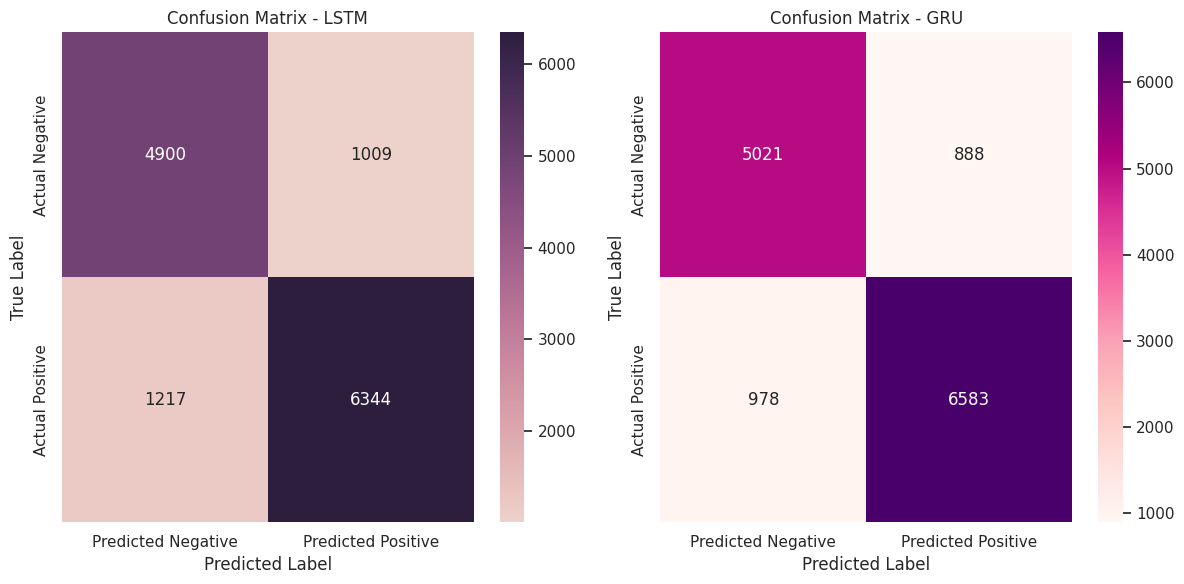

In [ ]:
cms = [cm_LSTM, cm_GRU]
model_names = ['LSTM', 'GRU']

plt.figure(figsize=(18, 6))
colour = [sns.cubehelix_palette(as_cmap=True),'RdPu','YlGnBu']

for i, cm in enumerate(cms, 1):
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap=colour[i-1],
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix - {model_names[i-1]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()